<a href="https://colab.research.google.com/github/TheMartinatorT800/AI4EO_22162567_AAUrmia/blob/main/AA_Urmia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentinel 2-Derived NDWI and NDVI for Monitoring Lake Urmia’s Surface Variability and Ecological Impact

This project investigates the surface water variability of Lake Urmia between 2016 and 2025, and its potential ecological impact on surrounding vegetation, using remote sensing techniques. Leveraging Sentinel-2 imagery, we can compute the Normalized Difference Water Index (NDWI) to delineate the lake’s surface area and the Normalized Difference Vegetation Index (NDVI) to assess vegetation health and coverage in the surrounding basin. By masking clouds and non-land pixels using SentinelHub’s dataMask, we can ensure accurate spatiotemporal comparisons. For water classification, a threshold of NDWI > 0.2 is validated through histogram analysis across years. Vegetation analysis is refined by excluding water pixels and computing mean NDVI values per year. To further explore landscape segmentation, K-Means clustering is applied to NDVI and NDWI datasets combined, classifying the region into water, vegetation, and bare terrain. A correlation analysis is then performed to examine how changes in lake surface area affected vegetation indices over time. The goal of this project is to provide a reproducible Earth Observation framework for monitoring inland water bodies and understanding their environmental influence using satellite-derived spectral indices.

##SETUP

Before starting the analysis, the project environment was prepared in Google Colab, a cloud-based platform that enables interactive development and access to external storage. The first step consists of mounting the Google Drive using drive.mount(), which is necessary to access the structured directory containing the Sentinel-2 NDWI, NDVI, and true-colour imagery for the years 2016, 2019, 2022, and 2025. This will allow the Colab notebook to use the required files from your Google Drive.

Essential geospatial and scientific Python libraries also need to be installed and imported. These include rasterio for reading and processing raster datasets, NumPy for numerical and array-based operations, matplotlib for data visualization, scikit-learn for applying K-Means clustering, and ListedColormap from matplotlib.colors to ensure consistent and interpretable colour representation across visual outputs.

Directory paths are defined to point to the NDWI and true-colour imagery folders, allowing easy reference to specific raster files across different years. This foundational setup ensures the data is accessible and the environment fully equipped for geospatial analysis and visualization.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

base_ndwi = '/content/drive/MyDrive/AA_Urmia/NDWI'
base_rgb = '/content/drive/MyDrive/AA_Urmia/TrueColour'
years = [2016, 2019, 2022, 2025]

#True Colour Visualization and Visualisation and NDWI

The goal of this function is to visually compare the surface water coverage of Lake Urmia with its corresponding true colour satellite imagery for each year in the study period (2016, 2019, 2022, and 2025). The cell defines a function display_comparison(year) that reads both the TrueColour composite and the NDWI-calculated raster for a specified year. True colour images were constructed using Sentinel-2 bands B04 (red), B03 (green), and B02 (blue), which were normalized to enhance contrast and visual consistency. The NDWI rasters were computed using bands B03 (green) and B08 (NIR), following the standard NDWI formula. A cloud and no-data mask was applied to exclude invalid pixels from the water index visualization. (ndvi[mask == 0] = np.nan)

The function then displays the two images side by side using matplotlib — the left showing the RGB true colour view of the region, and the right showing the NDWI values in a blue-scale colormap, where higher values correspond to water bodies. This visual juxtaposition helps validate the NDWI-derived water detection against actual spectral imagery and allows for intuitive, year-over-year comparison of changes in Lake Urmia’s surface area.

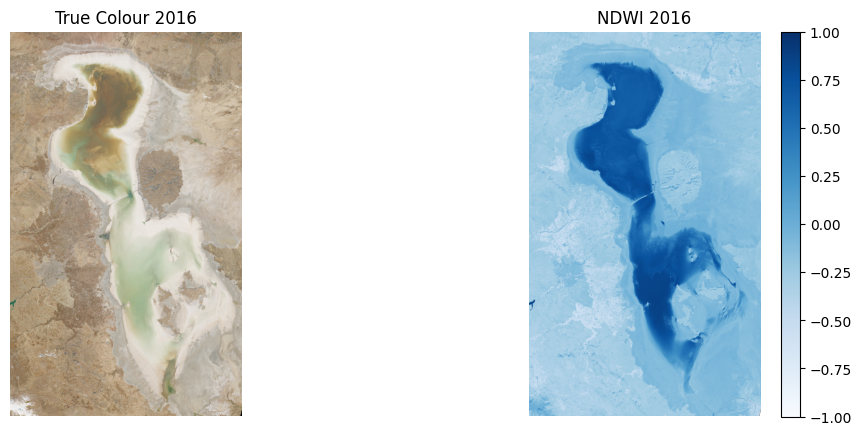

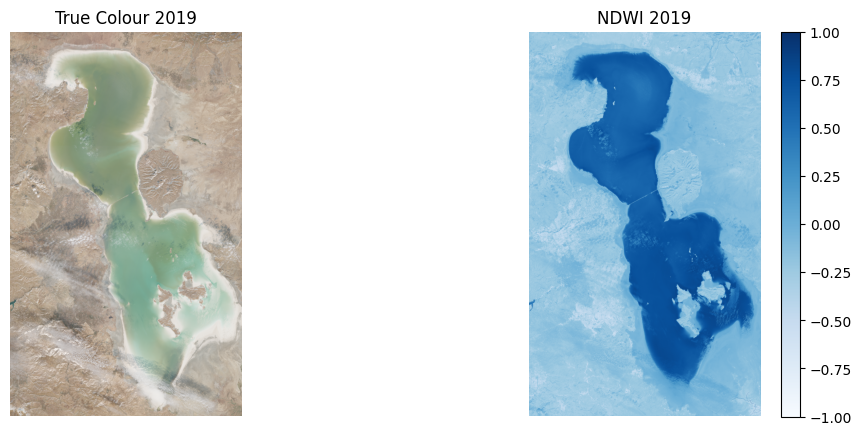

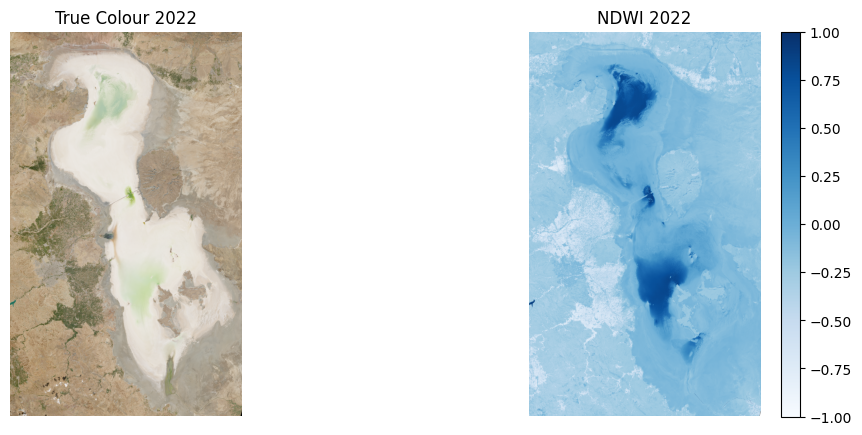

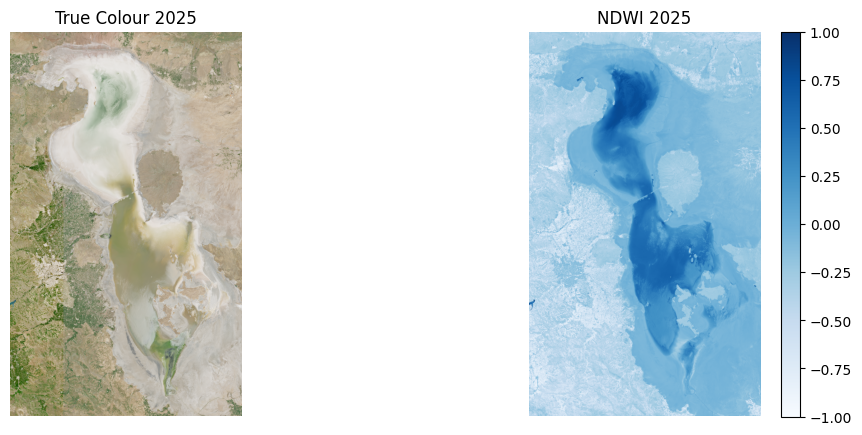

In [ ]:
base_ndwi = '/content/drive/MyDrive/AA_Urmia/NDWI'
base_rgb = '/content/drive/MyDrive/AA_Urmia/TrueColour'
years = [2016, 2019, 2022, 2025]

def display_comparison(year):
    rgb_path = f"{base_rgb}/TrueColour_{year}.tiff"
    ndwi_path = f"{base_ndwi}/NDWI_{year}.tiff"

    with rasterio.open(rgb_path) as src:
        r = src.read(1).astype('float32')
        g = src.read(2).astype('float32')
        b = src.read(3).astype('float32')
        rgb = np.stack([r, g, b], axis=-1)
        rgb = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb))  # Normalize to [0,1]

    with rasterio.open(ndwi_path) as src:
        green = src.read(1).astype('float32')
        nir = src.read(2).astype('float32')
        mask = src.read(3)
        ndwi = (green - nir) / (green + nir + 1e-6)
        ndwi[mask == 0] = np.nan

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.title(f"True Colour {year}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(ndwi, cmap='Blues', vmin=-1, vmax=1)
    plt.title(f"NDWI {year}")
    plt.colorbar()
    plt.axis('off')
    plt.show()

# Run the visualizations
for y in years:
    display_comparison(y)

##NDWI-Based Surface Water Area Calculation

This cell is designed to quantitatively estimate the surface area of Lake Urmia for the years 2016, 2019, 2022, and 2025, using the Normalized Difference Water Index (NDWI). The process begins by loading preprocessed NDWI TIFF files, which contain Sentinel-2 bands B03 (green) and B08 (near-infrared), along with a dataMask used to filter out clouds and no-data pixels. NDWI is calculated for each pixel using the standard formula, and a threshold of NDWI > 0.2 is applied to classify water pixels. The pixel resolution is determined dynamically based on the raster’s coordinate reference system, ensuring accurate area calculations regardless of projection. The total surface water area is computed by multiplying the number of water pixels by the pixel area and converting the result to square kilometers.

Each year’s binary water mask is then visualized to provide a spatial reference for the classification, while the computed areas are stored in a list for time series analysis. Finally, the script prints and plots the lake’s surface area over time, allowing for clear visualisation of trends in water coverage. This step is essential to assess hydrological changes in the lake and serves as the quantitative foundation for correlating water body variability with surrounding ecological indicators such as vegetation.

2016 - Water pixels: 622763, Area: 62.28 km²


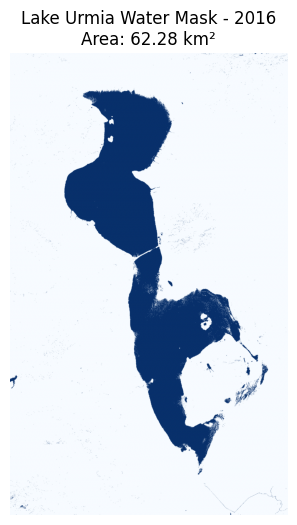

2019 - Water pixels: 1031443, Area: 103.14 km²


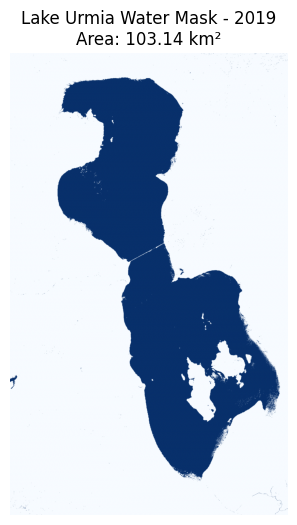

2022 - Water pixels: 222670, Area: 22.27 km²


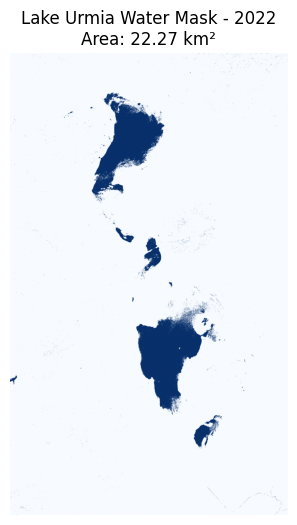

2025 - Water pixels: 498026, Area: 49.80 km²


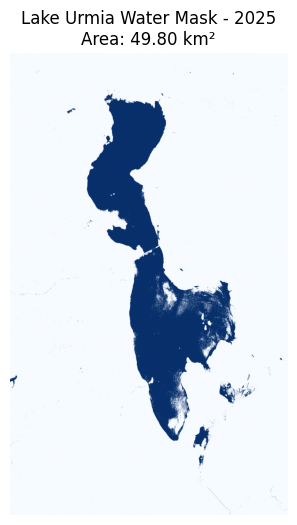


Lake Urmia Water Surface Area by Year:
2016: 62.28 km²
2019: 103.14 km²
2022: 22.27 km²
2025: 49.80 km²


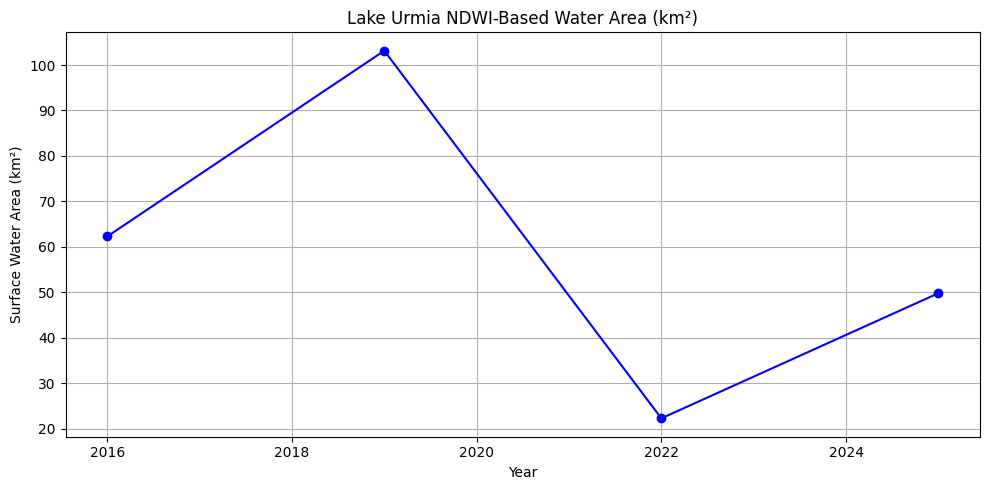

In [ ]:
base_ndwi = '/content/drive/MyDrive/AA_Urmia/NDWI'
years = [2016, 2019, 2022, 2025]
water_areas_km2 = []

def compute_ndwi_and_area(file_path, year):
    with rasterio.open(file_path) as src:
        green = src.read(1).astype('float32')  # B03
        nir = src.read(2).astype('float32')    # B08
        datamask = src.read(3)

        # NDWI formula
        ndwi = (green - nir) / (green + nir + 1e-6)
        ndwi[datamask == 0] = np.nan  # Mask out invalid pixels

        # NDWI threshold to detect water
        water_mask = ndwi > 0.2

        # FIXED PIXEL AREA
        crs = CRS.from_user_input(src.crs)
        if crs.is_geographic:
            pixel_area = 100  # assume Sentinel-2 10m resolution = 100 m²
        else:
            pixel_area = src.res[0] * src.res[1]

        total_pixels = np.nansum(water_mask)
        total_area_m2 = total_pixels * pixel_area
        area_km2 = total_area_m2 / 1e6

        print(f"{year} - Water pixels: {int(total_pixels)}, Area: {area_km2:.2f} km²")
        return ndwi, water_mask, area_km2

# LOOP THROUGH ALL YEARS
for year in years:
    file_path = f"{base_ndwi}/NDWI_{year}.tiff"
    ndwi_map, water_mask, area_km2 = compute_ndwi_and_area(file_path, year)
    water_areas_km2.append(area_km2)

    # Show mask
    plt.figure(figsize=(6, 6))
    plt.imshow(water_mask, cmap='Blues')
    plt.title(f'Lake Urmia Water Mask - {year}\nArea: {area_km2:.2f} km²')
    plt.axis('off')
    plt.show()

# PRINT + PLOT RESULTS
print("\nLake Urmia Water Surface Area by Year:")
for i, year in enumerate(years):
    print(f"{year}: {water_areas_km2[i]:.2f} km²")

plt.figure(figsize=(10, 5))
plt.plot(years, water_areas_km2, marker='o', color='blue')
plt.title("Lake Urmia NDWI-Based Water Area (km²)")
plt.xlabel("Year")
plt.ylabel("Surface Water Area (km²)")
plt.grid(True)
plt.tight_layout()
plt.show()

##NDWI Histogram Analysis

This cell generates a series of histograms to visualize the distribution of NDWI values for Lake Urmia across four years: 2016, 2019, 2022, and 2025. For each year, the script loads the corresponding NDWI raster, calculated from Sentinel-2 bands B03 (green) and B08 (NIR), and applies a dataMask to exclude invalid pixels such as clouds or missing data. The NDWI is computed using the standard formula and is flattened into a 1D array for histogram plotting.

Each histogram illustrates the frequency of NDWI values across all valid pixels, providing insight into the proportion of water and non-water surfaces. A vertical red line is drawn at NDWI = 0.2, the chosen threshold used throughout the analysis to distinguish surface water from land. This allows for immediate visual validation of the threshold’s effectiveness in separating water pixels. By comparing the shape and spread of these distributions over time, it is possible to detect shifts in surface water presence and evaluate hydrological changes over time in the lake. This step supports the thresholding method used in water area estimation and reinforces the robustness of NDWI as a surface water indicator.

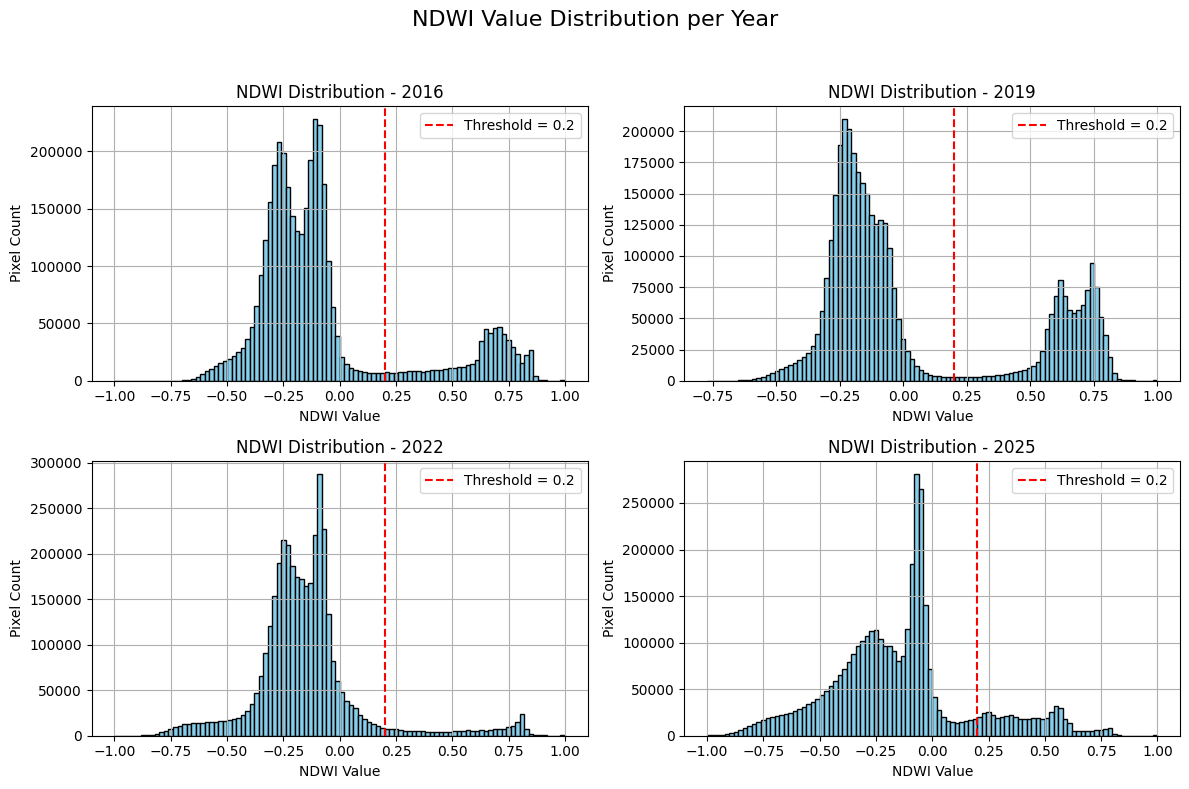

In [ ]:
ndwi_path = '/content/drive/MyDrive/AA_Urmia/NDWI'
years = [2016, 2019, 2022, 2025]

plt.figure(figsize=(12, 8))
for i, year in enumerate(years):
    path = f"{ndwi_path}/NDWI_{year}.tiff"

    with rasterio.open(path) as src:
        green = src.read(1).astype('float32')  # B03
        nir = src.read(2).astype('float32')    # B08
        mask = src.read(3)

        ndwi = (green - nir) / (green + nir + 1e-6)
        ndwi[mask == 0] = np.nan

    plt.subplot(2, 2, i + 1)
    plt.hist(ndwi[~np.isnan(ndwi)].flatten(), bins=100, color='skyblue', edgecolor='black')
    plt.axvline(x=0.2, color='red', linestyle='--', label='Threshold = 0.2')
    plt.title(f"NDWI Distribution - {year}")
    plt.xlabel("NDWI Value")
    plt.ylabel("Pixel Count")
    plt.grid(True)
    plt.legend()

plt.suptitle("NDWI Value Distribution per Year", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

##NDVI and NDWI Visual Comparison

This cell presents a side-by-side spatial comparison of the Normalized Difference Vegetation Index (NDVI) and the Normalized Difference Water Index (NDWI) for Lake Urmia across the study years 2016, 2019, 2022, and 2025. For each year, the corresponding preprocessed NDVI and NDWI GeoTIFF files are loaded. NDVI is calculated using Sentinel-2 bands B08 (NIR) and B04 (red), while NDWI is computed from bands B03 (green) and B08 (NIR). A cloud and no-data mask is applied in both cases to exclude invalid pixels and ensure accurate representation.

The function show_ndvi_ndwi_comparison() generates two side-by-side subplots: the NDVI map, displayed in a green colormap (YlGn), highlights the density of vegetation; the NDWI map, shown in blue, illustrates the presence of surface water. These paired visualisations enable clear qualitative assessment of how water and vegetation spatially relate to each other in each year, helping to contextualize the statistical correlation between lake surface changes and surrounding ecological conditions. This comparison is critical for identifying inverse spatial trends, such as vegetation retreat in response to lake shrinkage, and adds interpretability to the temporal data analysis.

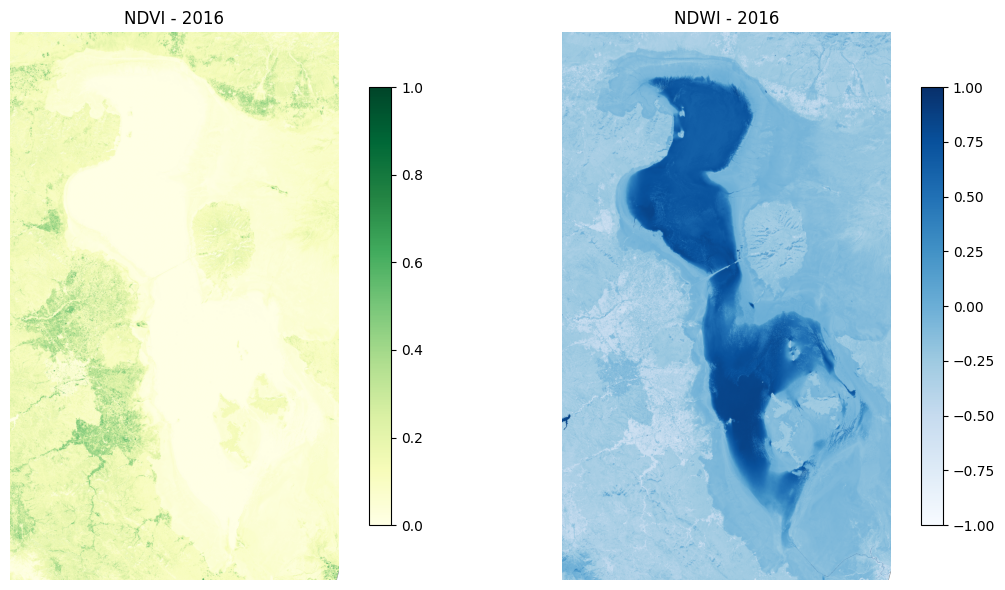

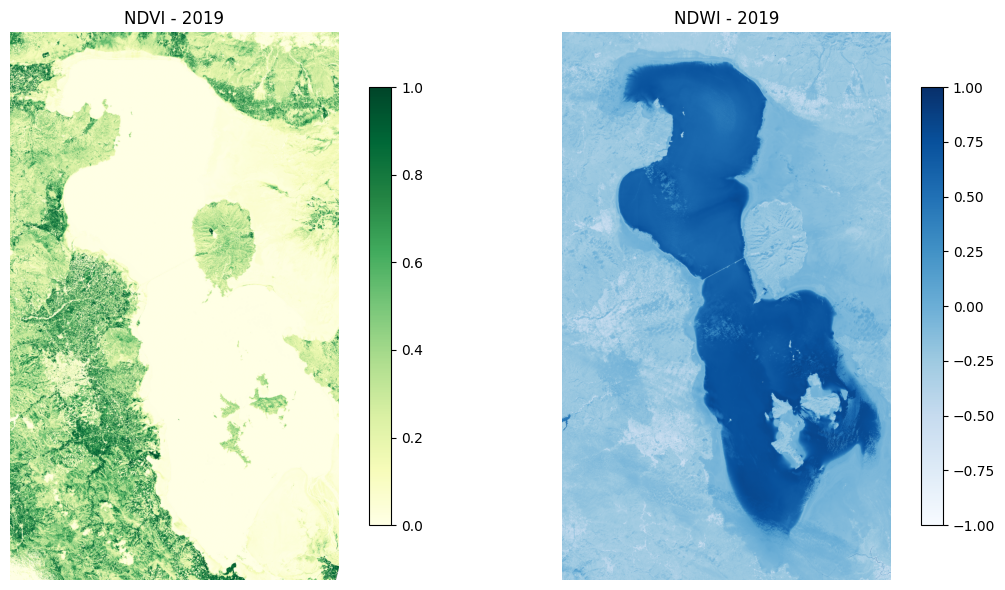

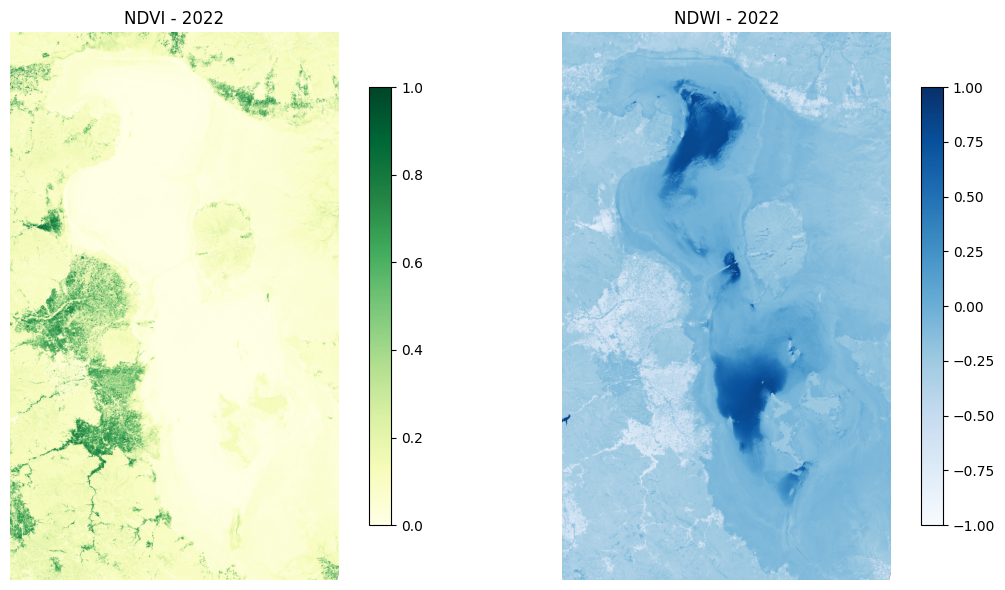

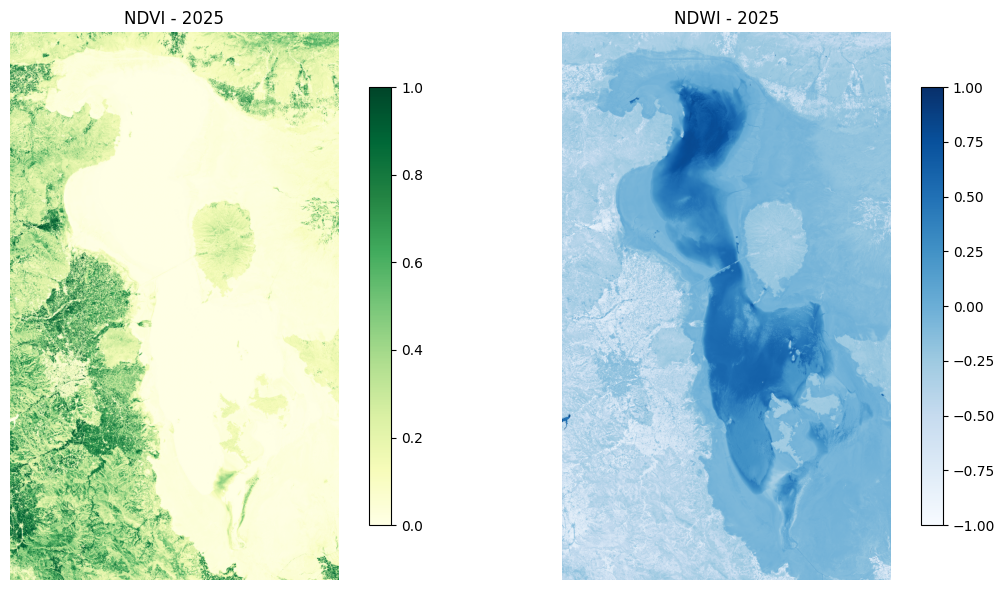

In [ ]:
def show_ndvi_ndwi_comparison(year):
    ndvi_file = f'/content/drive/MyDrive/AA_Urmia/NDVI/NDVI_{year}.tiff'
    ndwi_file = f'/content/drive/MyDrive/AA_Urmia/NDWI/NDWI_{year}.tiff'

    # Load NDVI
    with rasterio.open(ndvi_file) as src:
        nir = src.read(1).astype('float32')  # B08
        red = src.read(2).astype('float32')  # B04
        mask = src.read(3)
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi[mask == 0] = np.nan

    # Load NDWI
    with rasterio.open(ndwi_file) as src:
        green = src.read(1).astype('float32')  # B03
        nir_ndwi = src.read(2).astype('float32')  # B08
        mask = src.read(3)
        ndwi = (green - nir_ndwi) / (green + nir_ndwi + 1e-6) # NDWI formula
        ndwi[mask == 0] = np.nan

    # Plot Side-by-Side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    im1 = axs[0].imshow(ndvi, cmap='YlGn', vmin=0, vmax=1)
    axs[0].set_title(f"NDVI - {year}")
    axs[0].axis('off')
    fig.colorbar(im1, ax=axs[0], shrink=0.8)

    im2 = axs[1].imshow(ndwi, cmap='Blues', vmin=-1, vmax=1)
    axs[1].set_title(f"NDWI - {year}")
    axs[1].axis('off')
    fig.colorbar(im2, ax=axs[1], shrink=0.8)

    plt.tight_layout()
    plt.show()

# Show maps for all years
for y in [2016, 2019, 2022, 2025]:
    show_ndvi_ndwi_comparison(y)

##NDVI Calculation with Water Masking

This cell calculates the mean NDVI (Normalized Difference Vegetation Index) for the area surrounding Lake Urmia while excluding water-covered pixels. The goal is to assess vegetation health and coverage over time without the bias introduced by open water, which can distort NDVI values due to spectral reflectance differences.

For each of the four study years (2016, 2019, 2022, and 2025), NDVI rasters are loaded and computed using Sentinel-2 bands B08 (NIR) and B04 (red). Simultaneously, NDWI rasters are used to identify water pixels using a threshold of NDWI > 0.2. These water pixels are masked (set to NaN) in the NDVI array to ensure that only terrestrial vegetation is considered in the mean NDVI calculation. Both the NDVI and NDWI datasets apply cloud and no-data masking via SentinelHub’s dataMask to ensure only valid land observations are used.

The resulting water-masked mean NDVI values are stored and printed for each year, providing a temporal trend of vegetation response around the lake. This analysis supports the project’s broader aim of linking fluctuations in lake surface area with surrounding ecological conditions, particularly the health of nearby vegetation.

In [ ]:
ndvi_path = '/content/drive/MyDrive/AA_Urmia/NDVI'
ndwi_path = '/content/drive/MyDrive/AA_Urmia/NDWI'
years = [2016, 2019, 2022, 2025]
ndvi_means = []

print("Mean NDVI by Year (Water Masked):")
for year in years:
    ndvi_file = f"{ndvi_path}/NDVI_{year}.tiff"
    ndwi_file = f"{ndwi_path}/NDWI_{year}.tiff"

    # Load NDVI
    with rasterio.open(ndvi_file) as src:
        nir = src.read(1).astype('float32')  # B08
        red = src.read(2).astype('float32')  # B04
        mask = src.read(3)

        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi[mask == 0] = np.nan

    # Load NDWI to mask water
    with rasterio.open(ndwi_file) as src:
        green = src.read(1).astype('float32')  # B03
        nir_ndwi = src.read(2).astype('float32')  # B08
        datamask = src.read(3)

        ndwi = (green - nir_ndwi) / (green + nir_ndwi + 1e-6)
        ndwi[datamask == 0] = np.nan

    # Apply water mask
    ndvi[ndwi > 0.2] = np.nan  # Remove water pixels from NDVI

    # Compute mean NDVI over non-water, non-cloud
    mean_ndvi = np.nanmean(ndvi)
    ndvi_means.append(mean_ndvi)
    print(f"{year}: {mean_ndvi:.4f}")

Mean NDVI by Year (Water Masked):
2016: 0.1072
2019: 0.2217
2022: 0.1019
2025: 0.1891


##K-Means Classification Using NDVI and NDWI

This cell applies unsupervised land cover classification using the K-Means clustering algorithm on NDVI and NDWI indices for Lake Urmia and its surroundings across the years 2016, 2019, 2022, and 2025. The objective is to segment the region into three distinct land cover classes — water, vegetation, and other terrain — based on their spectral characteristics.

For each year, NDVI and NDWI rasters are computed from Sentinel-2 bands, and masked to exclude invalid or cloud-covered pixels. The indices are flattened and stacked into a two-dimensional feature space used as input for K-Means with 3 clusters. Since clustering is unsupervised, the resulting labels are reclassified using a post-clustering statistical function that examines the mean NDVI and NDWI values of each cluster. The cluster with the highest NDWI is assigned as water, the one with the highest NDVI as vegetation, and the remaining class as other terrain. To improve accuracy, pixels originally classified as vegetation but with NDVI < 0.15 are reclassified as other terrain to filter false positives.

The final result is a segmented raster map visualized with a consistent colormap: blue for water, green for vegetation, and orange for other terrain. This method enhances interpretability by providing a clear spatial overview of land cover composition and changes, supporting broader environmental analysis around Lake Urmia.

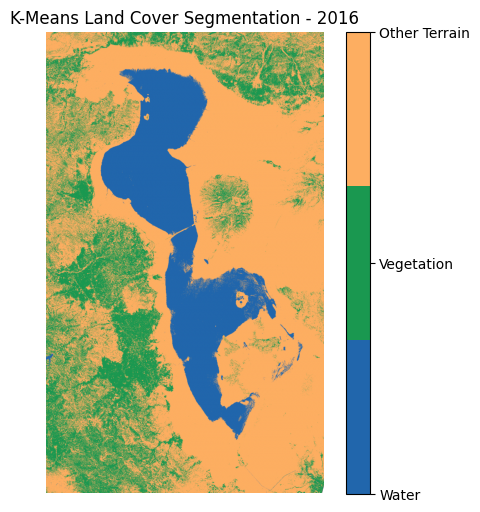

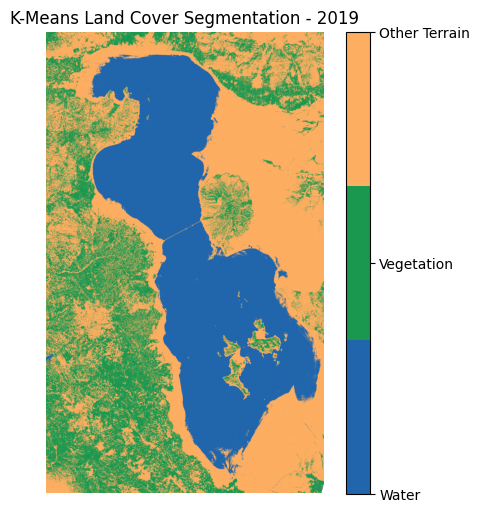

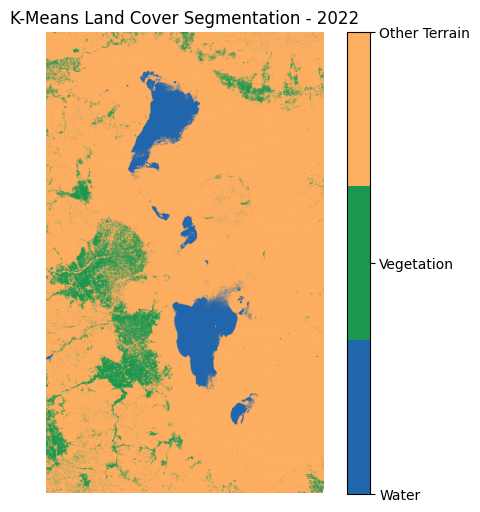

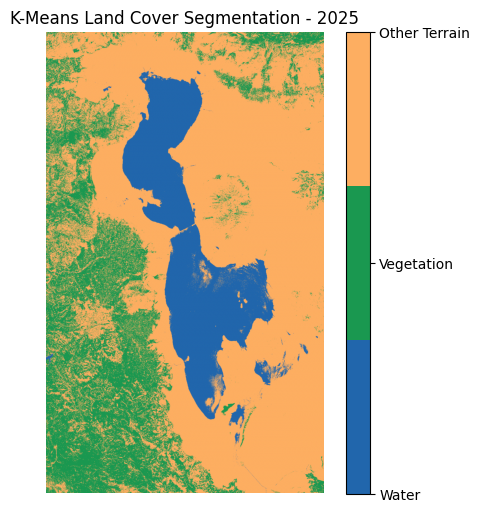

In [ ]:
def classify_clusters_by_stats(ndvi, ndwi, labels, valid_mask):
    flat_ndvi = ndvi.flatten()[valid_mask]
    flat_ndwi = ndwi.flatten()[valid_mask]

    cluster_means = []
    for i in range(3):
        mask = labels == i
        mean_ndvi = np.nanmean(flat_ndvi[mask])
        mean_ndwi = np.nanmean(flat_ndwi[mask])
        cluster_means.append((i, mean_ndvi, mean_ndwi))

    # Water = highest NDWI
    # Vegetation = highest NDVI
    # Other = remainder
    water_cluster = max(cluster_means, key=lambda x: x[2])[0]
    vegetation_cluster = max(cluster_means, key=lambda x: x[1])[0]
    other_cluster = list({0, 1, 2} - {water_cluster, vegetation_cluster})[0]

    return {
        water_cluster: 0,       # Blue
        vegetation_cluster: 1,  # Green
        other_cluster: 2        # Orange
    }

def cluster_ndvi_ndwi(year):
    ndvi_file = f'/content/drive/MyDrive/AA_Urmia/NDVI/NDVI_{year}.tiff'
    ndwi_file = f'/content/drive/MyDrive/AA_Urmia/NDWI/NDWI_{year}.tiff'

    # Load NDVI
    with rasterio.open(ndvi_file) as src:
        nir = src.read(1).astype('float32')
        red = src.read(2).astype('float32')
        ndvi_mask = src.read(3)
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi[ndvi_mask == 0] = np.nan

    # Load NDWI
    with rasterio.open(ndwi_file) as src:
        green = src.read(1).astype('float32')
        nir_ndwi = src.read(2).astype('float32')
        ndwi_mask = src.read(3)
        ndwi = (green - nir_ndwi) / (green + nir_ndwi + 1e-6)
        ndwi[ndwi_mask == 0] = np.nan

    # Stack + Mask
    flat_ndvi = ndvi.flatten()
    flat_ndwi = ndwi.flatten()
    valid_mask = ~np.isnan(flat_ndvi) & ~np.isnan(flat_ndwi)
    X = np.stack([flat_ndvi[valid_mask], flat_ndwi[valid_mask]], axis=1)

    # KMeans
    km = KMeans(n_clusters=3, random_state=42)
    raw_labels = km.fit_predict(X)

    # Re-map Labels
    cluster_map = classify_clusters_by_stats(ndvi, ndwi, raw_labels, valid_mask)
    mapped_labels = np.array([cluster_map[label] for label in raw_labels])

    # Rebuild label image
    label_img = np.full_like(flat_ndvi, np.nan)
    label_img[valid_mask] = mapped_labels
    label_img = label_img.reshape(ndvi.shape)

    # Filter false vegetation (NDVI < 0.15 → not green enough)
    label_img[(label_img == 1) & (ndvi < 0.15)] = 2  # Reassign to Other

    # Plot with consistent color legend
    cmap = ListedColormap(['#2166ac', '#1a9850', '#fdae61'])  # Blue, Green, Orange
    plt.figure(figsize=(6, 6))
    im = plt.imshow(label_img, cmap=cmap, vmin=0, vmax=2)
    cbar = plt.colorbar(im, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Water', 'Vegetation', 'Other Terrain'])
    plt.title(f"K-Means Land Cover Segmentation - {year}")
    plt.axis('off')
    plt.show()

# Run for all years
for y in [2016, 2019, 2022, 2025]:
    cluster_ndvi_ndwi(y)

##NDVI and Surface Water Area Correlation Plot

This cell visualizes the temporal relationship between Lake Urmia’s surface water area and mean NDVI values across four observation years: 2016, 2019, 2022, and 2025. A dual-axis plot is used to effectively compare these two variables with differing units and scales. The left y-axis represents lake surface area (in km²), plotted in blue, while the right y-axis shows the mean NDVI, plotted in green. Both trends are displayed using line graphs with markers to emphasize individual yearly data points.

This visualization aims to highlight potential inverse or correlated dynamics between lake shrinkage and surrounding vegetation health. For example, years with reduced surface water area may correspond to lower NDVI values, suggesting a possible ecological impact on vegetation due to changing hydrological conditions. By plotting these indicators together, this analysis visually supports further statistical or causal interpretation regarding the interaction between surface water availability and vegetation trends in the Lake Urmia basin.

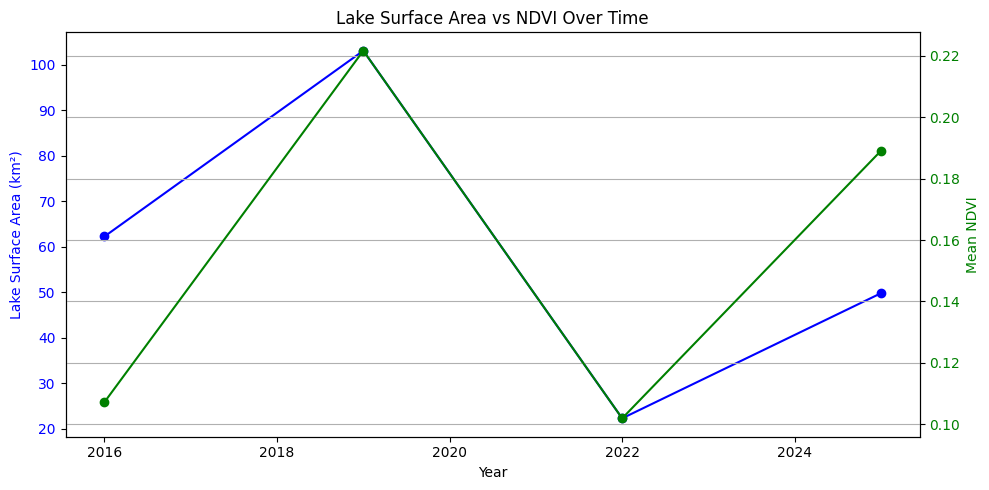

In [ ]:
years = [2016, 2019, 2022, 2025]
water_areas_km2 = [62.28, 103.14, 22.27, 49.80]
ndvi_means = [0.1072, 0.2217, 0.1019, .1891]  # ← paste from your output

# PLOT NDVI + WATER SURFACE COMPARISON
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("Year")
ax1.set_ylabel("Lake Surface Area (km²)", color='blue')
ax1.plot(years, water_areas_km2, marker='o', color='blue', label='Water Surface Area')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel("Mean NDVI", color='green')
ax2.plot(years, ndvi_means, marker='o', color='green', label='NDVI')
ax2.tick_params(axis='y', labelcolor='green')

plt.title("Lake Surface Area vs NDVI Over Time")
fig.tight_layout()
plt.grid(True)
plt.show()

#Conclusion

This project successfully demonstrated a robust remote sensing workflow to monitor surface water fluctuations and vegetation dynamics in Lake Urmia using freely available Sentinel-2 imagery. Through accurate application of NDWI and NDVI indices, coupled with land cover classification via K-Means clustering, the study revealed a clear correlation between lake Urmias’s surface area and the abundance of its surrounding vegetation from 2016 to 2025. Notably, the lowest water extent and vegetation health were observed in 2022, while 2019 marked the peak for both indicators, highlighting their ecological interdependence.

Each component of the pipeline—from cloud-masked image preprocessing to the extraction of quantitative trends—performed reliably and produced consistent, interpretable results. The visual outputs, area calculations, and dual-axis correlation plot collectively validated the methodology and confirmed the project’s goal: to provide a spatial-temporal understanding of lake-ecosystem variability. The techniques used proved to be both efficient and scalable, laying a strong foundation for similar environmental monitoring studies anywhere in the world. Ultimately, this project stands as a successful example of how Earth observation and open-source analytics can yield meaningful insights for environmental science and policy.

The use of freely available Sentinel-2 imagery, along with open-source geospatial libraries, makes this approach cost-effective, repeatable, and adaptable across time and space. Whether for seasonal monitoring of reservoirs, long-term tracking of drought-prone lakes, or assessing the impact of water policy on agriculture, this workflow provides a robust framework for evidence-based environmental decision-making.